# Emerging Computer Technologies - quantum task

### Try to get familiar with qiskit transpiler

In [28]:
from qiskit import QuantumCircuit, transpile
from qiskit.test.mock.backends import FakeBrooklyn
import time

In [2]:
backend = FakeBrooklyn()
input_path = './original/adder-3.qasm'

In [3]:
def qasmFromPath(input_path, backend):
    qc = QuantumCircuit.from_qasm_file(path=input_path)
    qc_transpiled = transpile(qc, backend=backend)
    filename = './output/test.qasm'
    qc_transpiled.qasm(filename=filename)
    return qc_transpiled

In [4]:
def qasmOptimization(path, backend):
    qc = QuantumCircuit.from_qasm_file(path=path)
    qc_transpiled = []
    for i in range(3):
        qc_transpiled.append(transpile(qc, backend=backend, optimization_level=i))
        filename = './output/test' + str(i) + '.qasm'
        qc_transpiled[i].qasm(filename=filename)
    return qc_transpiled

### Try to get familiar with circuit's representation

This is the input circuit mapped to the 65qubits fake-device with the Transpiler given by qiskit

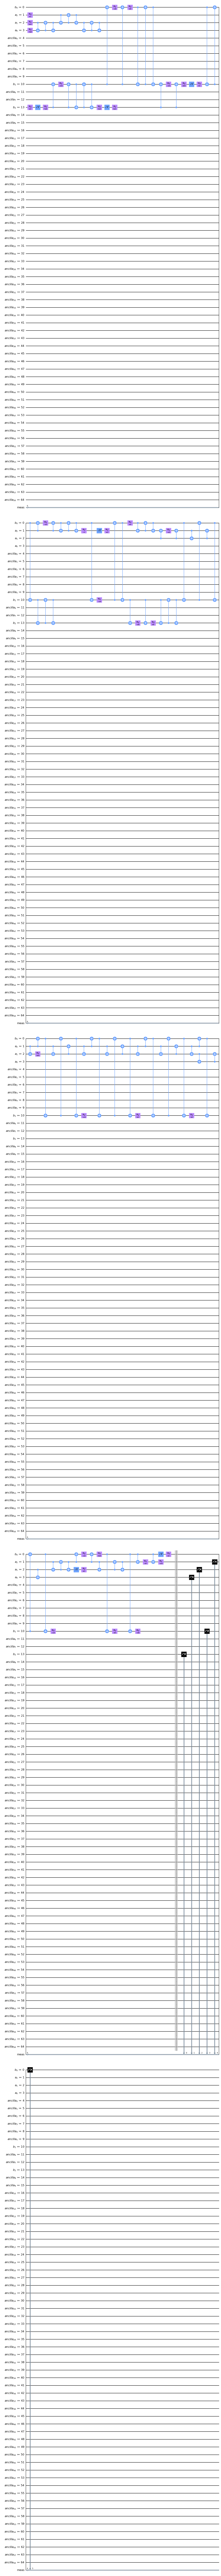

In [5]:
qc_transpiled = qasmFromPath(input_path, backend)
qc_transpiled.draw(output='mpl')

\
\
Let's try to use different kind of transpilers and see the differences in terms of optimization

In [6]:
# TODO try to print several circuits with different optimization
transpilers = qasmOptimization(input_path, backend)
transpilers[0].draw(output='mpl')
for t in transpilers:
    t.draw(output='mpl')

## Try to get familiar with FakeBrooklyn circuit

In [7]:
# take some information on FakeBrooklyn circuit
map = backend.configuration().gates
print(type(map[len(map)-2]))
coupling_list = map[len(map)-2].coupling_map
print('Coupling map -------- \n', type(coupling_list), coupling_list)

print('\n\nBut later I discovered a faster method...\n')
map_easy = backend.configuration().coupling_map
print('coupling easy--', map_easy)

#qubits
num_qubits =  backend.configuration().n_qubits
print('\nnum qubits of device--', num_qubits)

<class 'qiskit.providers.models.backendconfiguration.GateConfig'>
Coupling map -------- 
 <class 'list'> [[0, 1], [0, 10], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3], [4, 5], [4, 11], [5, 4], [5, 6], [6, 5], [6, 7], [7, 6], [7, 8], [8, 7], [8, 9], [8, 12], [9, 8], [10, 0], [10, 13], [11, 4], [11, 17], [12, 8], [12, 21], [13, 10], [13, 14], [14, 13], [14, 15], [15, 14], [15, 16], [15, 24], [16, 15], [16, 17], [17, 11], [17, 16], [17, 18], [18, 17], [18, 19], [19, 18], [19, 20], [19, 25], [20, 19], [20, 21], [21, 12], [21, 20], [21, 22], [22, 21], [22, 23], [23, 22], [23, 26], [24, 15], [24, 29], [25, 19], [25, 33], [26, 23], [26, 37], [27, 28], [27, 38], [28, 27], [28, 29], [29, 24], [29, 28], [29, 30], [30, 29], [30, 31], [31, 30], [31, 32], [31, 39], [32, 31], [32, 33], [33, 25], [33, 32], [33, 34], [34, 33], [34, 35], [35, 34], [35, 36], [35, 40], [36, 35], [36, 37], [37, 26], [37, 36], [38, 27], [38, 41], [39, 31], [39, 45], [40, 35], [40, 49], [41, 38], [41, 42], [42, 4

### Understand and use BasicMapper pass (from qiskit)
\
Now I know that I can give an initial_layout like the one described by my device - in practical how many qubits and clbits my final circuit will have. 
\
i.e. The device has 65qubits but the input circuit can have less, so I must **convert the input circuit** (or DAG depending on the representation) **so that it has the same qubits and clbits as the final circuit (the device).**

In [8]:
from copy import copy

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler import Layout
from qiskit.circuit.library import SwapGate


class BasicSwap(TransformationPass):
    """Maps (with minimum effort) a DAGCircuit onto a `coupling_map` adding swap gates."""

    def __init__(self,
                 coupling_map,
                 initial_layout=None):
        """Maps a DAGCircuit onto a `coupling_map` using swap gates.

        Args:
            coupling_map (CouplingMap): Directed graph represented a coupling map.
            initial_layout (Layout): initial layout of qubits in mapping
        """
        super().__init__()
        self.coupling_map = coupling_map
        self.initial_layout = initial_layout

    def run(self, dag):
        """Runs the BasicSwap pass on `dag`.

        Args:
            dag (DAGCircuit): DAG to map.

        Returns:
            DAGCircuit: A mapped DAG.

        Raises:
            TranspilerError: if the coupling map or the layout are not
            compatible with the DAG.
        """
        new_dag = DAGCircuit()
        for qreg in dag.qregs.values():
            new_dag.add_qreg(qreg)
        for creg in dag.cregs.values():
            new_dag.add_creg(creg)


        if self.initial_layout is None:
            if self.property_set["layout"]:
                self.initial_layout = self.property_set["layout"]
            else:
                self.initial_layout = Layout.generate_trivial_layout(*dag.qregs.values())
          
        if len(dag.qubits) != len(self.initial_layout):
            raise TranspilerError('The layout does not match the amount of qubits in the DAG')

        if len(self.coupling_map.physical_qubits) != len(self.initial_layout):
            raise TranspilerError(
                "Mappers require to have the layout to be the same size as the coupling map")

        canonical_register = dag.qregs['q']
        trivial_layout = Layout.generate_trivial_layout(canonical_register)
        current_layout = trivial_layout.copy()

        for layer in dag.serial_layers():
            subdag = layer['graph']

            for gate in subdag.two_qubit_ops():
                physical_q0 = current_layout[gate.qargs[0]]
                physical_q1 = current_layout[gate.qargs[1]]
                if self.coupling_map.distance(physical_q0, physical_q1) != 1:
                    # Insert a new layer with the SWAP(s).
                    swap_layer = DAGCircuit()
                    swap_layer.add_qreg(canonical_register)

                    path = self.coupling_map.shortest_undirected_path(physical_q0, physical_q1)
                    for swap in range(len(path) - 2):
                        connected_wire_1 = path[swap]
                        connected_wire_2 = path[swap + 1]

                        qubit_1 = current_layout[connected_wire_1]
                        qubit_2 = current_layout[connected_wire_2]

                        # create the swap operation
                        swap_layer.apply_operation_back(SwapGate(),
                                                        qargs=[qubit_1, qubit_2],
                                                        cargs=[])

                    # layer insertion
                    order = current_layout.reorder_bits(new_dag.qubits)
                    new_dag.compose(swap_layer, qubits=order)

                    # update current_layout
                    for swap in range(len(path) - 2):
                        current_layout.swap(path[swap], path[swap + 1])

            order = current_layout.reorder_bits(new_dag.qubits)
            new_dag.compose(subdag, qubits=order)

        return new_dag

## Try to get familiar with DAG from qiskit
\
Let's take a qasm file as input and display his DAG.

QuantumRegister(8, 'a') QuantumRegister(8, 'b')


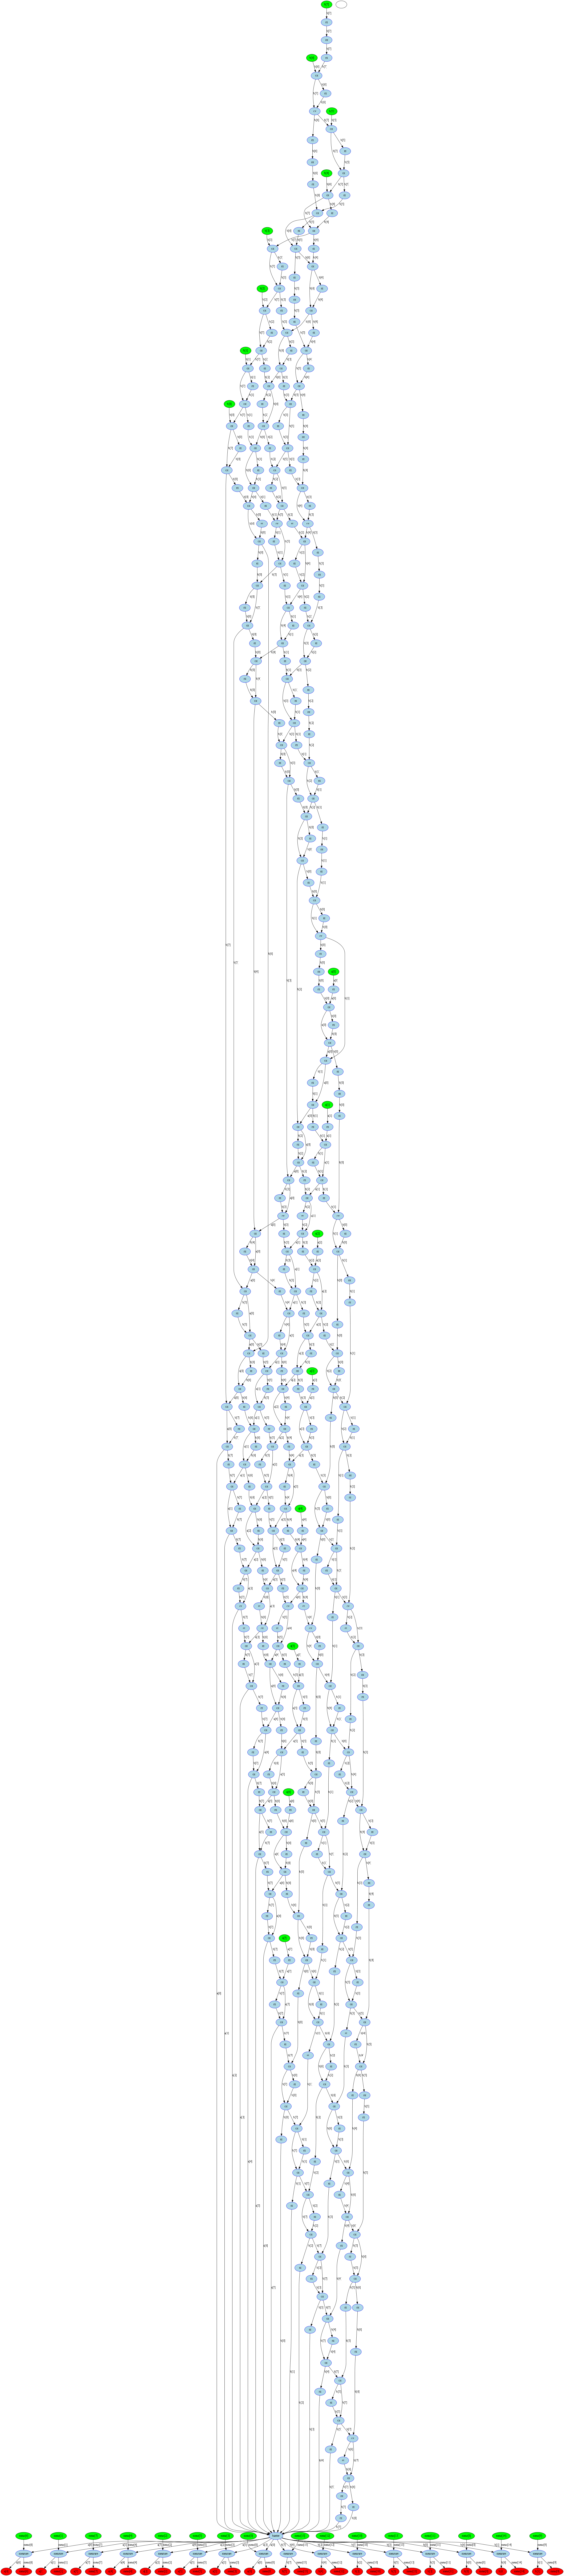

In [9]:
from qiskit.transpiler import CouplingMap
from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer
from qiskit.dagcircuit import DAGCircuit

%matplotlib inline
input_path = './original/adder-8.qasm'
qc = QuantumCircuit.from_qasm_file(path=input_path)
input_DAG = circuit_to_dag(qc) 
print(*input_DAG.qregs.values())
dag_drawer(input_DAG)

There exists also a representation of the coupling map, and drawing the coupling map of the FakeBrooklyn device you can see how it looks like (i.e. **coupled qubits** in the device)

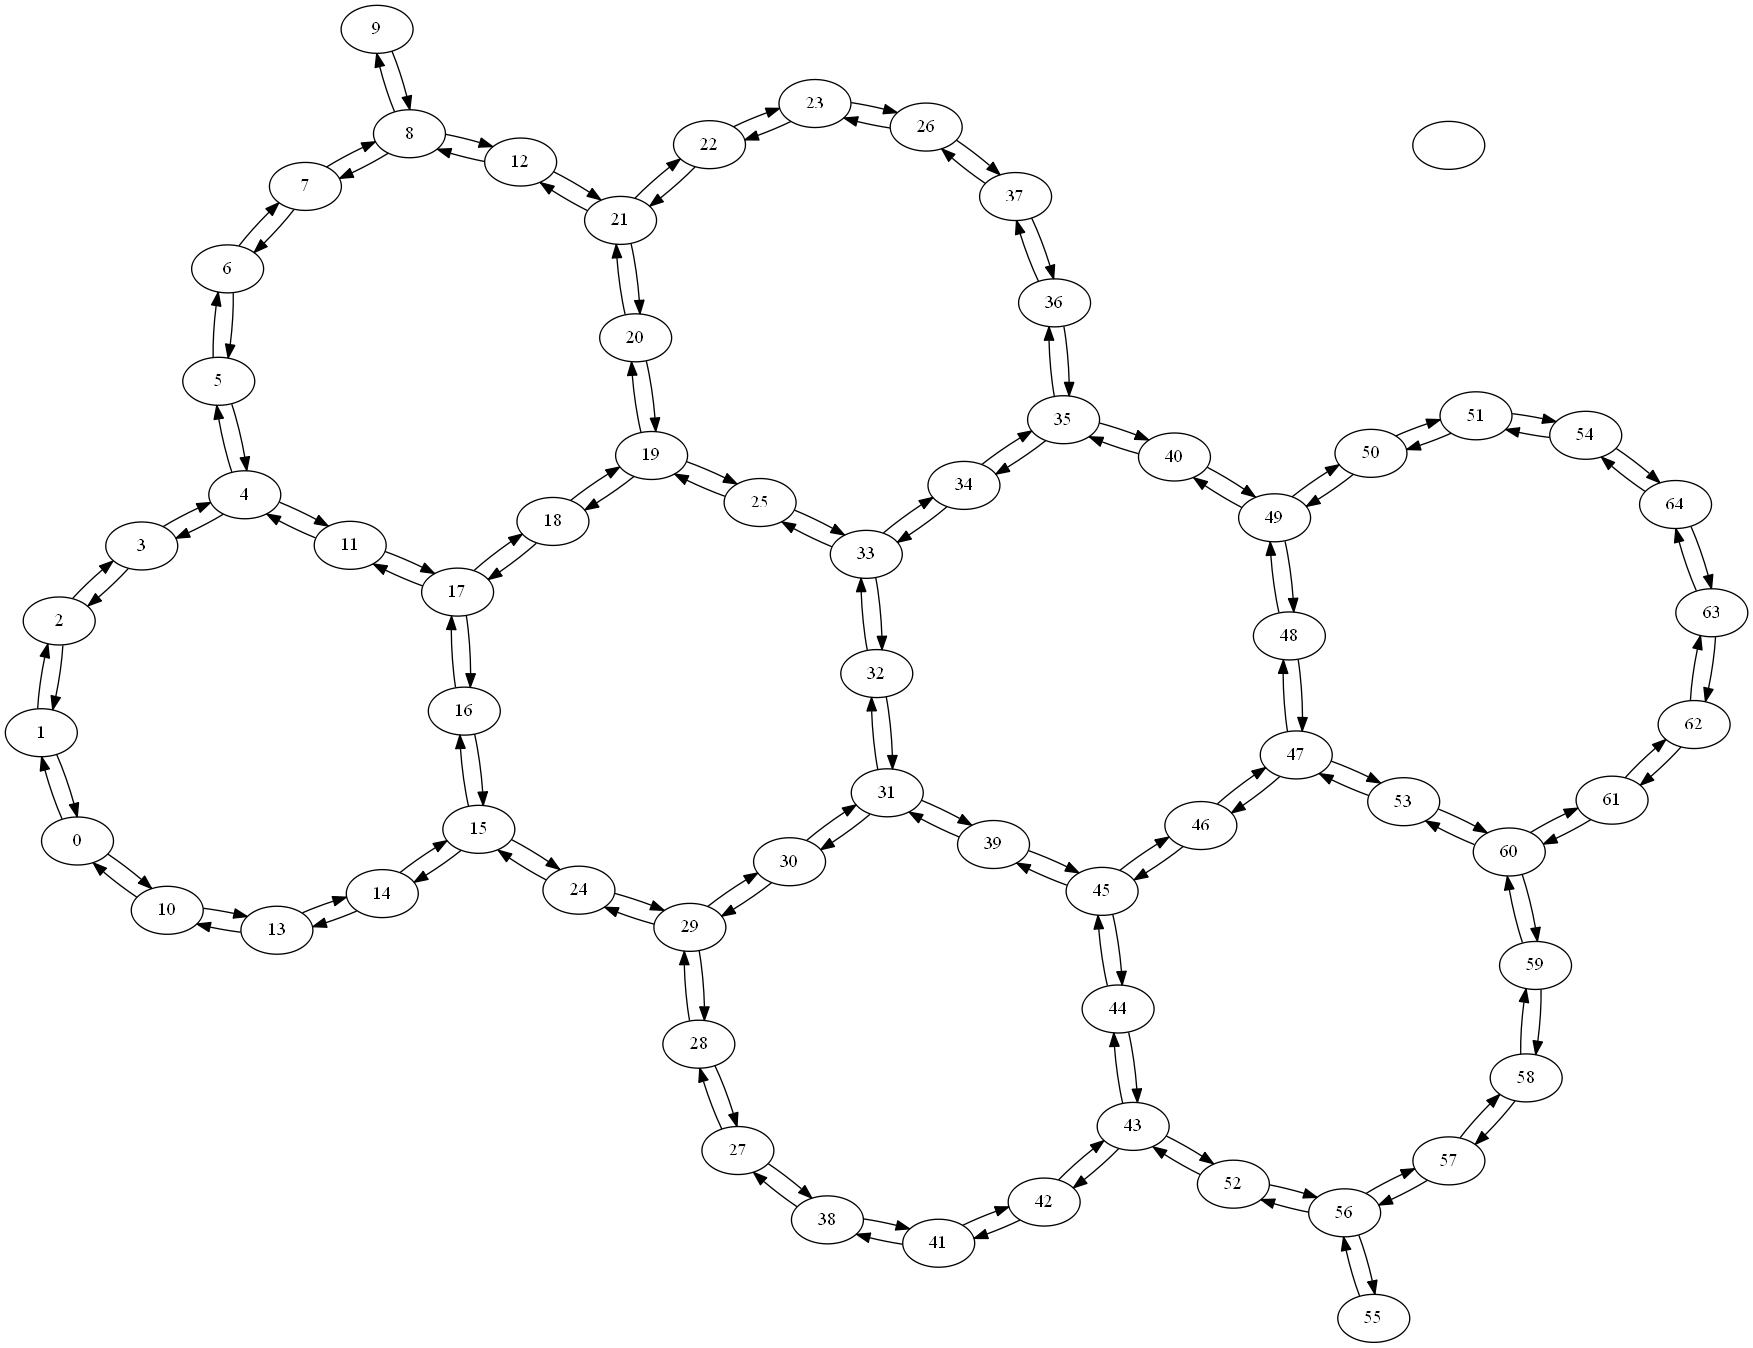

In [10]:
coupling_map = CouplingMap(couplinglist=coupling_list)
coupling_map.draw()

# Let's use the BasicPass!
\
First of all you need to have a DAG of the input circuit that has the same dimension of the device (in terms of qubits and clbits). 
\
Note that a lot of qubits will be unused now, but they can be useful for later optimizations!

In [11]:
from qiskit.transpiler import Layout

# create a circuit the same size as the device, in terms of qubits and clbits
device_qc = QuantumCircuit(num_qubits, num_qubits)
device_DAG = circuit_to_dag(device_qc) 
initial_layout = Layout.generate_trivial_layout(*device_DAG.qregs.values())

# take the input circuit
input_path2 = './original/adder-3.qasm'
qc2 = QuantumCircuit.from_qasm_file(path=input_path2)
input_DAG2 = circuit_to_dag(qc2) 

# build the input_DAG (n qubits) on the device_DAG (65 qubits)
device_DAG.compose(input_DAG2)
#device_DAG.draw(filename='./output/dag_circuit3.jpg')

Now you can **create and run the BasicPass**: it will add **SWAP** gates so that the coupling constraint is satisfied. A lot of gates are added, so we must do subsequent optimizations.
\
Note that the final DAG image is too large, so you have to save it in a file.

In [12]:
basic_pass = BasicSwap(coupling_map, initial_layout)
out_DAG2 = basic_pass.run(device_DAG)
#out_DAG.draw(filename='./output/dag_circuit.jpg')

And we can also visualize the corresponding **quantum circuit** with the added SWAP.

In [13]:
from qiskit.converters import dag_to_circuit
final_qc2 = dag_to_circuit(out_DAG2)
final_qc2.draw()

┌──────────┐                                                          »
 q_0: ┤ Rz(7π/8) ├──X─────────────────X─────────────────────────────────────»
      ├──────────┤  │                 │                                     »
 q_1: ┤ Rz(3π/4) ├──X────────X────────X─────────────────────────────────────»
      ├─────────┬┘           │                                              »
 q_2: ┤ Rz(π/2) ├────────────X──────────────────────────────────────────────»
      └─────────┘                                                           »
 q_3: ──────────────────────────────────────────────────────────────────────»
                                    ┌───┐┌──────────┐┌───┐┌──────────┐┌────┐»
 q_4: ──────────────────────────────┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(3π/4) ├┤ √X ├»
      ┌─────────┐ ┌────┐┌──────────┐└─┬─┘└──────────┘└─┬─┘└──────────┘└────┘»
 q_5: ┤ Rz(π/2) ├─┤ √X ├┤ Rz(7π/8) ├──■────────────────■────────────────────»
      └─────────┘ └────┘└──────────┘                                        »
 q_6: ──────────────────────────────────────────────────────────────────────»
                                                                            »
 q_7: ──────────────────────────────────────────────────────────────────────»
                                                                            »
 q_8: ──────────────────────────────────────────────────────────────────────»
                                                                            »
 q_9: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_10: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_11: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_12: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_13: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_14: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_15: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_16: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_17: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_18: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_19: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_20: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_21: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_22: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_23: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_24: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_25: ──────────────────────

# Define costs of gates

In [14]:
RZ = 0
X = 1
SX = 1
CNOT = 10
SWAP = 30

In [15]:
def compute_cost(dag_circuit):
    gates = {'rz': 0, 'rx': 0, 'sx': 0, 'cx': 0, 'swap': 0}
    count_ops = dag_circuit.count_ops()
    gates.update(count_ops)
    print('gates---\n',gates)
    
    #for this project only these costs are assigned
    rz_cost = RZ * gates['rz']
    x_cost = X * gates['rx']
    sx_cost = SX * gates['sx']
    cnot_cost = CNOT * gates['cx']
    swap_cost = SWAP * gates['swap']
    
    total_cost = rz_cost + x_cost + sx_cost + cnot_cost + swap_cost
    print('\n\nCost of the circuit:',total_cost)
    
    return total_cost

### Let's try the function with our initial mapped circuit:

In [16]:
cost1 = compute_cost(out_DAG2)

gates---
 {'rz': 34, 'rx': 0, 'sx': 6, 'cx': 24, 'swap': 18, 'barrier': 1, 'measure': 6}


Cost of the circuit: 786


### Too high isn't it? We must do optimizations! 
The first idea that came up to my mind was to **reorder qubits in the easiest way possible** (to begin :) ) that still permits to achieve a reduction of the final cost of the circuit. How to do this? Firstly you create a **layout** (it's a dictionary which describes the mapping between lagical and physical qubits) and then you apply the basic pass.

The **class TopologicalAssignment** maps the logical qubits in this way: starting from the top layer of the DAG describing the circuit you want to run on the device, whenever you encounter a two-quibits operation map these two qubits to two physical coupled qubits, if it's still possible; otherwise, map the qubits such that they are as close as possible on the device, so less swap operations will be needed. If a qubit has already been mapped do not map it again. At the end, map all the virtual qubits that don't have yet a corresponding physical qubit (because not part of any two-qubits operation).

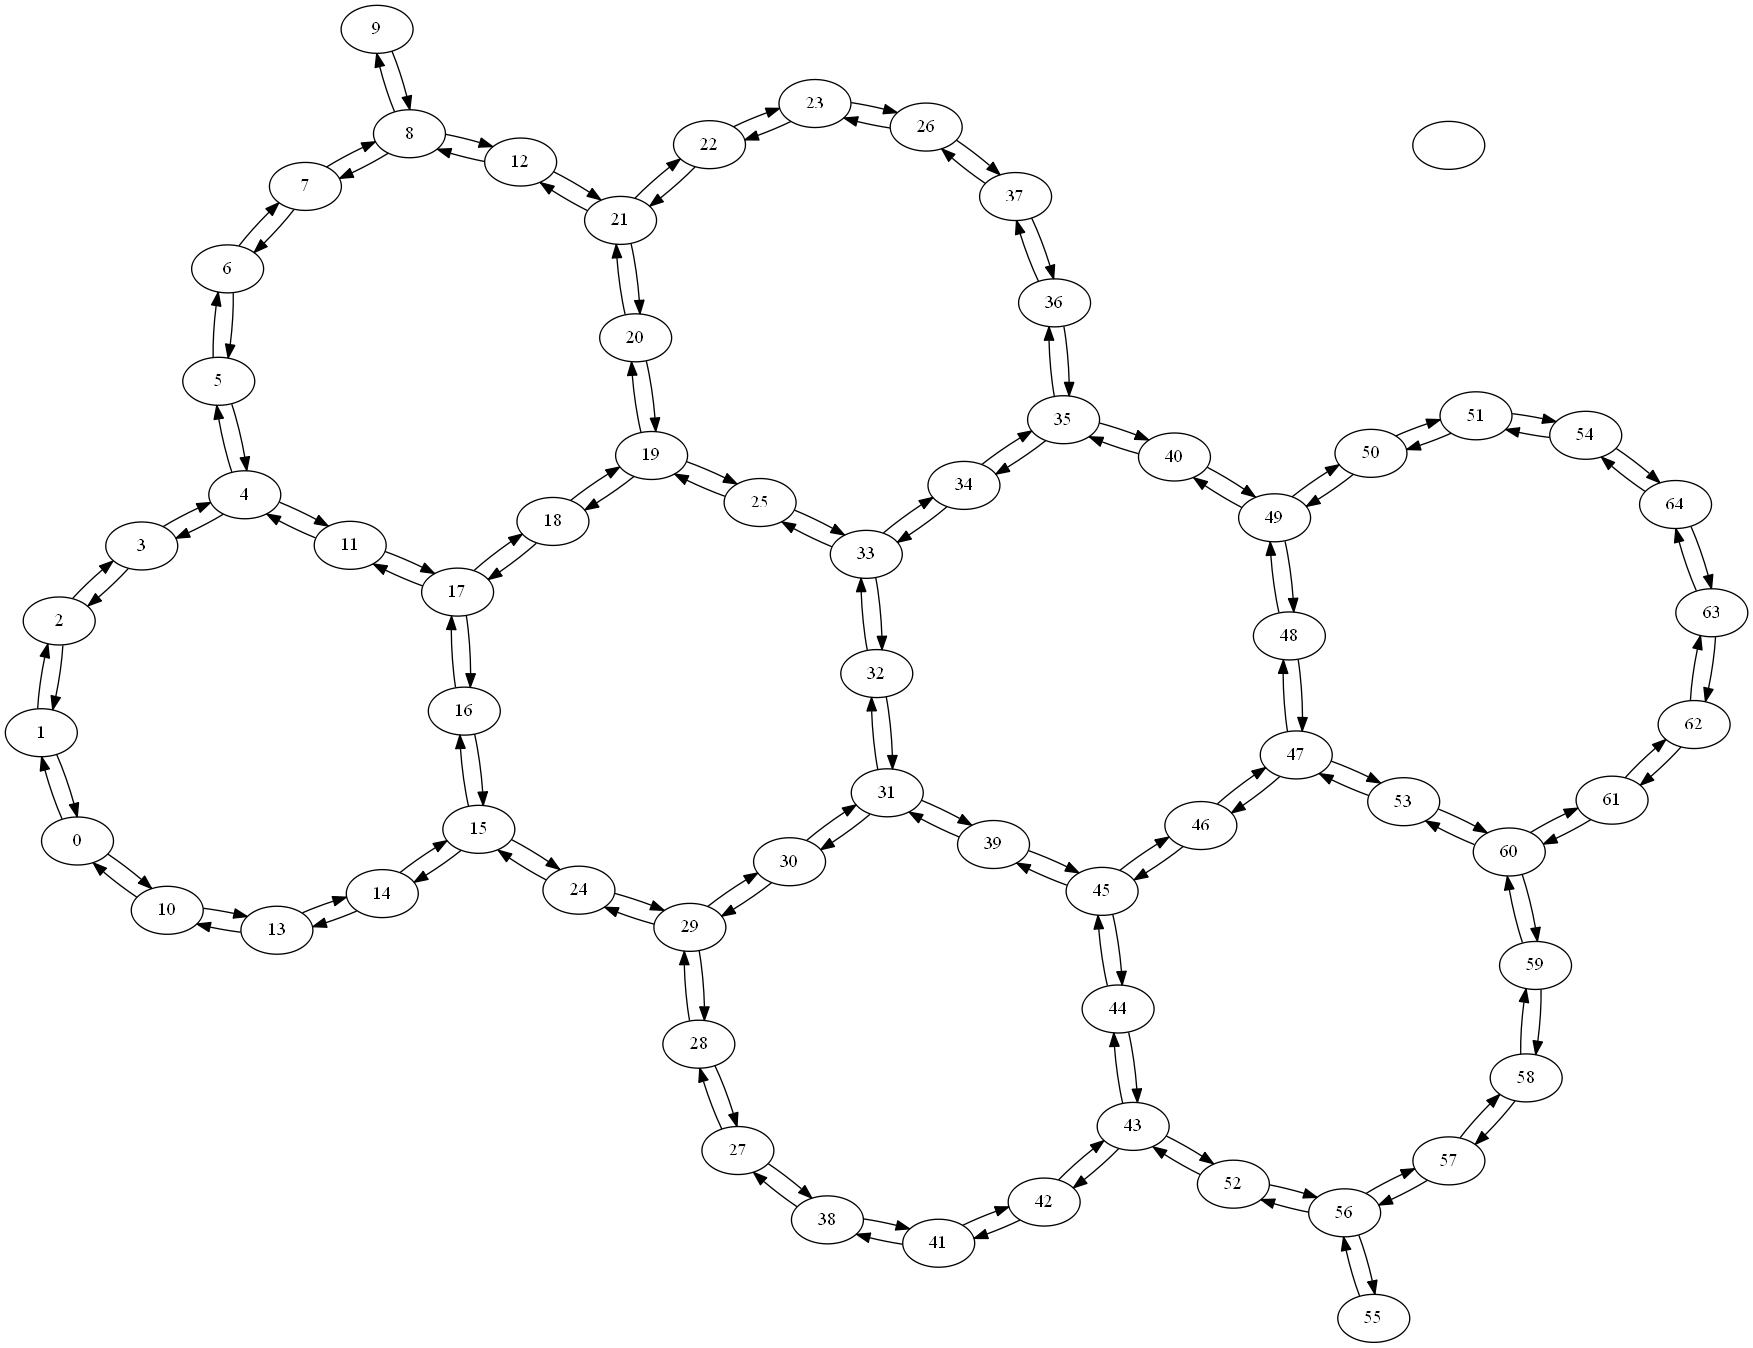

In [17]:
coupling_map.draw()

# Topological Assignment

In [18]:
from qiskit.transpiler import TranspilerError
import random

"""
Given the coupling map of a real device and a dag circuit, 
create a layout (map physical qubits to logical) that permits
to have less costs when a basic pass is used

"""

class topologicalAssignment():
    
    def __init__(self,
                 coupling_map):
        
        self.coupling_map = coupling_map
        self.num_qubits = 65
        
    def run(self, dag):
        
        # create an empty dictionary from a 65 qubit device         
        canonical_register = dag.qregs['q']
        trivial_layout = Layout.generate_trivial_layout(canonical_register)
                
        # initialize layout dictionary
        # keys --> virtual, values --> physical
        # layout_dict[virtual_qbit] to access the physical
        # list(layout_dict.values()) to retrieve the physical qubits used
        layout_dict = trivial_layout.copy().get_virtual_bits() 
        
        # initialize the dictionary such that each virtual qubits is not assigned
        # to any physical qubit
        for virtual in layout_dict.keys():
            layout_dict[virtual] = None
        
        # i: arbitrary starting qubit
        # the ideal is to start mapping the qubits from qubits 
        # which are located in the center of the circuit 
        # (see coupling_map drawing above)
        i = 31
        
        ###
        assignments = []
        ###
        
        # walk through the dag searching for two-qubits operations
        for layer in dag.serial_layers():
            subdag = layer['graph']
            for gate in subdag.two_qubit_ops():

                physical_q0 = layout_dict[gate.qargs[0]]
                physical_q1 = layout_dict[gate.qargs[1]]
                switched = 0

                ###
                a = False
                b = False
                if physical_q0 == None:
                    a = True
                if physical_q1 == None:
                    b = True
                ###
                # gate defines a two qubits op with virtual qubits gate.qargs[0] and gate.qargs[1]
                if physical_q0 == None: #physical qubit not associated yet
                    if physical_q1 == None:
                        layout_dict[gate.qargs[0]] = i
                        physical_q0 = i
                    else:
                        physical_q0 = layout_dict[gate.qargs[1]] 
                        physical_q1 = layout_dict[gate.qargs[0]]
                        switched = 1  # keep track that now physical_q0 contains virtual_q1
 
                # physical_q0 is now assigned
                if physical_q1 == None: #physical qubit not associated yet
                    assigned = False                    
                    distance_q0 = self.coupling_map.distance_matrix[physical_q0].copy()
                    physical_assigned = [x for x in layout_dict.values() if x is not None]
                    
                    # starting from qubits with distance 1, take all the qubits that 
                    # have that distance from physical_q0 (candidates): if one of them is not assigned yet,
                    # assign it, otherwise increase the distance allowed
                    for j in range(1, int(distance_q0.max()) + 1):  #let j as close as possible to physical_q0
                        candidates = [index for index, element in enumerate(distance_q0) if element == j] #element is the distance from q0
                        random.shuffle(candidates)
                        
                        for n in candidates: #search in the nearest qubits wrt q0
                            if n not in physical_assigned:
                                layout_dict[gate.qargs[1 - switched]] = n
                                physical_q1 = n
                                assigned = True
                                break
                        if assigned == True:
                            break
                            
                    # physical_q1 should be assigned
                    if assigned == False:
                        raise TranspilerError('The layout does not match the amount of qubits in the DAG')                    
                    
                physical_assigned =  [x for x in layout_dict.values() if x is not None] 
                if len(physical_assigned) == self.num_qubits: # the mapping is completed
                    break
                    
                while i in physical_assigned:  #let i as close as possible to the previous qubits
                    i += 1
                    if i == 65:
                        i = 0
                        
                ###
                if a is True:
                    assignments.append(physical_q0 if not switched else physical_q1)
                    a = False
                if b is True:
                    assignments.append(physical_q1 if not switched else physical_q0)
                    b = False
                ###
                
        print('\n-->This is how physical qubits have been assigned by the algorithm (in order):\n', assignments)
                
        physical = [x for x in layout_dict.values() if x is not None]
        print('\n\nNum of physical unique qubit assigned (without unused qubits): --',len(physical), ' out of ', len(layout_dict.keys()))

        # map all the unused qubits
        used = [x for x in layout_dict.values() if x is not None]
        total = list(range(0, self.num_qubits))
        unused = [x for x in total if x not in used]  
        
        for virtual in layout_dict.keys():
            if layout_dict[virtual] == None:
                layout_dict[virtual] = unused[0]
                unused.pop(0)
        
        #check        
        physical = set(layout_dict.values())
        print('\nNum of physical unique qubit assigned (with used qubits): --',len(physical), ' out of ', len(layout_dict.keys()))
        
        layout = Layout(layout_dict)
        return layout
    

In [19]:
qc4 = QuantumCircuit.from_qasm_file(path=input_path2)
input_DAG4 = circuit_to_dag(qc4) 

device_qc4 = QuantumCircuit(num_qubits, num_qubits)
device_DAG4 = circuit_to_dag(device_qc4) 

# build the input_DAG (n qubits) on the device_DAG (65 qubits)
device_DAG4.compose(input_DAG4)
tp = topologicalAssignment(coupling_map)
tp_layout = tp.run(device_DAG4)
print('\n--------------Mapping-------------\n---Physical qubit : Virtual qubit---\n', tp_layout)


-->This is how physical qubits have been assigned by the algorithm (in order):
 [31, 30, 39, 45, 29, 32]


Num of physical unique qubit assigned (without unused qubits): -- 6  out of  65

Num of physical unique qubit assigned (with used qubits): -- 65  out of  65

--------------Mapping-------------
---Physical qubit : Virtual qubit---
 Layout({
45: Qubit(QuantumRegister(65, 'q'), 0),
29: Qubit(QuantumRegister(65, 'q'), 1),
32: Qubit(QuantumRegister(65, 'q'), 2),
39: Qubit(QuantumRegister(65, 'q'), 3),
30: Qubit(QuantumRegister(65, 'q'), 4),
31: Qubit(QuantumRegister(65, 'q'), 5),
0: Qubit(QuantumRegister(65, 'q'), 6),
1: Qubit(QuantumRegister(65, 'q'), 7),
2: Qubit(QuantumRegister(65, 'q'), 8),
3: Qubit(QuantumRegister(65, 'q'), 9),
4: Qubit(QuantumRegister(65, 'q'), 10),
5: Qubit(QuantumRegister(65, 'q'), 11),
6: Qubit(QuantumRegister(65, 'q'), 12),
7: Qubit(QuantumRegister(65, 'q'), 13),
8: Qubit(QuantumRegister(65, 'q'), 14),
9: Qubit(QuantumRegister(65, 'q'), 15),
10: Qubit(Quantu

### Now you have the layout 
so you can use it as input of the Basic pass. n.b. You must use this modified version of the basic pass that doesn't build another trivial layout but uses the layout given as parameter.

In [20]:
from copy import copy

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler import Layout
from qiskit.circuit.library import SwapGate


class BasicSwapModified(TransformationPass):
    """Maps (with minimum effort) a DAGCircuit onto a `coupling_map` adding swap gates."""

    def __init__(self,
                 coupling_map,
                 initial_layout=None):
        """Maps a DAGCircuit onto a `coupling_map` using swap gates.

        Args:
            coupling_map (CouplingMap): Directed graph represented a coupling map.
            initial_layout (Layout): initial layout of qubits in mapping
        """
        super().__init__()
        self.coupling_map = coupling_map
        self.initial_layout = initial_layout

    def run(self, dag):
        """Runs the BasicSwap pass on `dag`.

        Args:
            dag (DAGCircuit): DAG to map.

        Returns:
            DAGCircuit: A mapped DAG.

        Raises:
            TranspilerError: if the coupling map or the layout are not
            compatible with the DAG.
        """
        new_dag = DAGCircuit()
        for qreg in dag.qregs.values():
            new_dag.add_qreg(qreg)
        for creg in dag.cregs.values():
            new_dag.add_creg(creg)


        if self.initial_layout is None:
            if self.property_set["layout"]:
                self.initial_layout = self.property_set["layout"]
            else:
                self.initial_layout = Layout.generate_trivial_layout(*dag.qregs.values())
       
        if len(dag.qubits) != len(self.initial_layout):
            print('qubits on the device:--- ', len(dag.qubits), '\nqubits on the input circuit (layout):--- ',len(self.initial_layout))
            raise TranspilerError('The layout does not match the amount of qubits in the DAG')

        if len(self.coupling_map.physical_qubits) != len(self.initial_layout):
            raise TranspilerError(
                "Mappers require to have the layout to be the same size as the coupling map")

        canonical_register = dag.qregs['q']
        #trivial_layout = Layout.generate_trivial_layout(canonical_register)
        #current_layout = trivial_layout.copy()
        
        # here: use as current layout the layout given (which should be the optimized layout)
        current_layout = self.initial_layout.copy()
        for layer in dag.serial_layers():
            subdag = layer['graph']

            for gate in subdag.two_qubit_ops():
                physical_q0 = current_layout[gate.qargs[0]]
                physical_q1 = current_layout[gate.qargs[1]]
                if self.coupling_map.distance(physical_q0, physical_q1) != 1:
                    # Insert a new layer with the SWAP(s).
                    swap_layer = DAGCircuit()
                    swap_layer.add_qreg(canonical_register)

                    path = self.coupling_map.shortest_undirected_path(physical_q0, physical_q1)
                    for swap in range(len(path) - 2):
                        connected_wire_1 = path[swap]
                        connected_wire_2 = path[swap + 1]

                        qubit_1 = current_layout[connected_wire_1]
                        qubit_2 = current_layout[connected_wire_2]

                        # create the swap operation
                        swap_layer.apply_operation_back(SwapGate(),
                                                        qargs=[qubit_1, qubit_2],
                                                        cargs=[])

                    # layer insertion
                    order = current_layout.reorder_bits(new_dag.qubits)
                    new_dag.compose(swap_layer, qubits=order)

                    # update current_layout
                    for swap in range(len(path) - 2):
                        current_layout.swap(path[swap], path[swap + 1])

            order = current_layout.reorder_bits(new_dag.qubits)
            new_dag.compose(subdag, qubits=order)

        return new_dag

In [21]:
basic_pass2 = BasicSwapModified(coupling_map, tp_layout)
out_DAG2o = basic_pass2.run(device_DAG)
print('The cost of the first circuit was: ', cost1, '\n\n\nwhile with the optimization you have:\n')
cost2 = compute_cost(out_DAG2o)

The cost of the first circuit was:  786 


while with the optimization you have:

gates---
 {'rz': 34, 'rx': 0, 'sx': 6, 'cx': 24, 'swap': 11, 'barrier': 1, 'measure': 6}


Cost of the circuit: 576


In [22]:
#out_DAG2o.draw(filename='./output/dag_circuit3_optimized.png')

# Done!
The number of the swaps has decreased a lot due to the optimization of the initial layout, adapted to the input circuit. You can see that **the total cost of the circuit has decreased** as well!

# Next Step:
## compare the solution with qiskit transpiler
Show **how much topological mapping solution departs** from qiskit state of the art solutions (qiskit transpilers are used)

In [23]:
from tabulate import tabulate
from qiskit import QuantumCircuit, transpile
import os

In [24]:
# return a list of costs with the following mappers: 
# basic_swap, lv0, lv1, lv2, lv3, topological_assignment
def compute_costs(qc):
    # create a circuit the same size as the device, in terms of qubits and clbits
    new_qc = qc.copy()
    new_device_qc = QuantumCircuit(num_qubits, num_qubits)
    new_device_DAG = circuit_to_dag(new_device_qc) 
    new_initial_layout = Layout.generate_trivial_layout(*new_device_DAG.qregs.values())
    
    new_input_DAG = circuit_to_dag(new_qc) 
    

    # build the input_DAG on the device_DAG (65 qubits)
    new_device_DAG.compose(new_input_DAG)
    
    # for basic pass
    basic_pass = BasicSwap(coupling_map, new_initial_layout)
    new_dag_basic_pass = basic_pass.run(new_device_DAG)
    cost_basic_pass = compute_cost(new_dag_basic_pass)
        
    # for traspiler lv0
    new_circ_lv0 = transpile(qc, backend=backend, optimization_level=0)
    new_dag_lv0 = circuit_to_dag(new_circ_lv0)
    cost0 = compute_cost(new_dag_lv0)

    # for traspiler lv1
    new_circ_lv1 = transpile(qc, backend=backend, optimization_level=1)
    new_dag_lv1 = circuit_to_dag(new_circ_lv1)
    cost1 = compute_cost(new_dag_lv1)

    # for traspiler lv2
    new_circ_lv2 = transpile(qc, backend=backend, optimization_level=2)
    new_dag_lv2 = circuit_to_dag(new_circ_lv2)
    cost2 = compute_cost(new_dag_lv2)

    # for traspiler lv3
    new_circ_lv3 = transpile(qc, backend=backend, optimization_level=3)
    new_dag_lv3 = circuit_to_dag(new_circ_lv3)
    cost3 = compute_cost(new_dag_lv3)
    
    # for topological assignment
    new_qc2 = qc.copy()
    new_input_DAG2 = circuit_to_dag(new_qc2) 
    
    # build the input_DAG on the device_DAG (65 qubits)
    new_device_qc2 = QuantumCircuit(num_qubits, num_qubits)
    new_device_DAG2 = circuit_to_dag(new_device_qc2) 
    new_device_DAG2.compose(new_input_DAG2)
    
    tp = topologicalAssignment(coupling_map)
    tp_layout = tp.run(new_device_DAG2)
    basic_pass_modified = BasicSwapModified(coupling_map, tp_layout)
    new_dag_tp_assignmnet = basic_pass_modified.run(new_device_DAG2)
    cost_tp_assignment = compute_cost(new_dag_tp_assignmnet)
    
    return [cost_basic_pass, cost0, cost1, cost2, cost3, cost_tp_assignment]

In [25]:
folderpath = r".\original" # make sure to put the 'r' in front
filepaths  = [os.path.join(folderpath, name) for name in os.listdir(folderpath)]
table_rows = []

for i in range(5):
#for i in range(len(filepaths)):
    print('------------iteration ', i, '-----------  file: ', filepaths[i], '----------')
    input_path3 = filepaths[i]
    qc3 = QuantumCircuit.from_qasm_file(path=input_path3)
    costs = compute_costs(qc3)
    
    row = [input_path3.rsplit('\\', 1)[1]]
    row.extend(costs)
    table_rows.append(row)  

------------iteration  0 -----------  file:  .\original\adder-13.qasm ----------
gates---
 {'rz': 534, 'rx': 0, 'sx': 26, 'cx': 494, 'swap': 874, 'barrier': 1, 'measure': 26}


Cost of the circuit: 31186
gates---
 {'rz': 534, 'rx': 0, 'sx': 26, 'cx': 2750, 'swap': 0, 'barrier': 1, 'measure': 26}


Cost of the circuit: 27526
gates---
 {'rz': 534, 'rx': 0, 'sx': 26, 'cx': 2494, 'swap': 0, 'barrier': 1, 'measure': 26}


Cost of the circuit: 24966
gates---
 {'rz': 534, 'rx': 0, 'sx': 26, 'cx': 2293, 'swap': 0, 'barrier': 1, 'measure': 26}


Cost of the circuit: 22956
gates---
 {'rz': 973, 'rx': 0, 'sx': 363, 'cx': 1315, 'swap': 0, 'x': 35, 'barrier': 1, 'measure': 26}


Cost of the circuit: 13513

-->This is how physical qubits have been assigned by the algorithm (in order):
 [31, 32, 30, 39, 29, 33, 45, 24, 25, 44, 28, 46, 34, 35, 47, 27, 43, 19, 15, 52, 20, 14, 53, 38, 40, 18]


Num of physical unique qubit assigned (without unused qubits): -- 26  out of  65

Num of physical unique qubit

In [26]:
table = [['benchmark name', 'basic swap', 'lv=0', 'lv=1', 'lv=2', 'lv=3', 'topological assignment']]
table.extend(table_rows)

print('--------------------------- Cost in terms of gates-------------------------------------------------------')
print(tabulate(table,headers='firstrow', tablefmt='fancy_grid', numalign='center'))

--------------------------- Cost in terms of gates-------------------------------------------------------
╒═══════════════════╤══════════════╤════════╤════════╤════════╤════════╤══════════════════════════╕
│ benchmark name    │  basic swap  │  lv=0  │  lv=1  │  lv=2  │  lv=3  │  topological assignment  │
╞═══════════════════╪══════════════╪════════╪════════╪════════╪════════╪══════════════════════════╡
│ adder-13.qasm     │    31186     │ 27526  │ 24966  │ 22956  │ 13513  │          29446           │
├───────────────────┼──────────────┼────────┼────────┼────────┼────────┼──────────────────────────┤
│ adder-16.qasm     │    48202     │ 37642  │ 39522  │ 37012  │ 22146  │          47272           │
├───────────────────┼──────────────┼────────┼────────┼────────┼────────┼──────────────────────────┤
│ adder-3.qasm      │     786      │  906   │  816   │  676   │  416   │           576            │
├───────────────────┼──────────────┼────────┼────────┼────────┼────────┼──────────────────────

# Let's see 
How topological assignment performs on multiple benchmarks. We can see that **for some problems it performs very well** (closer to qiskit transpiler lv=3) while **for other problems it performs really bad**, in some cases even worse than just applying a basic swap.


An interesting research would be to find the similarities between these problems...

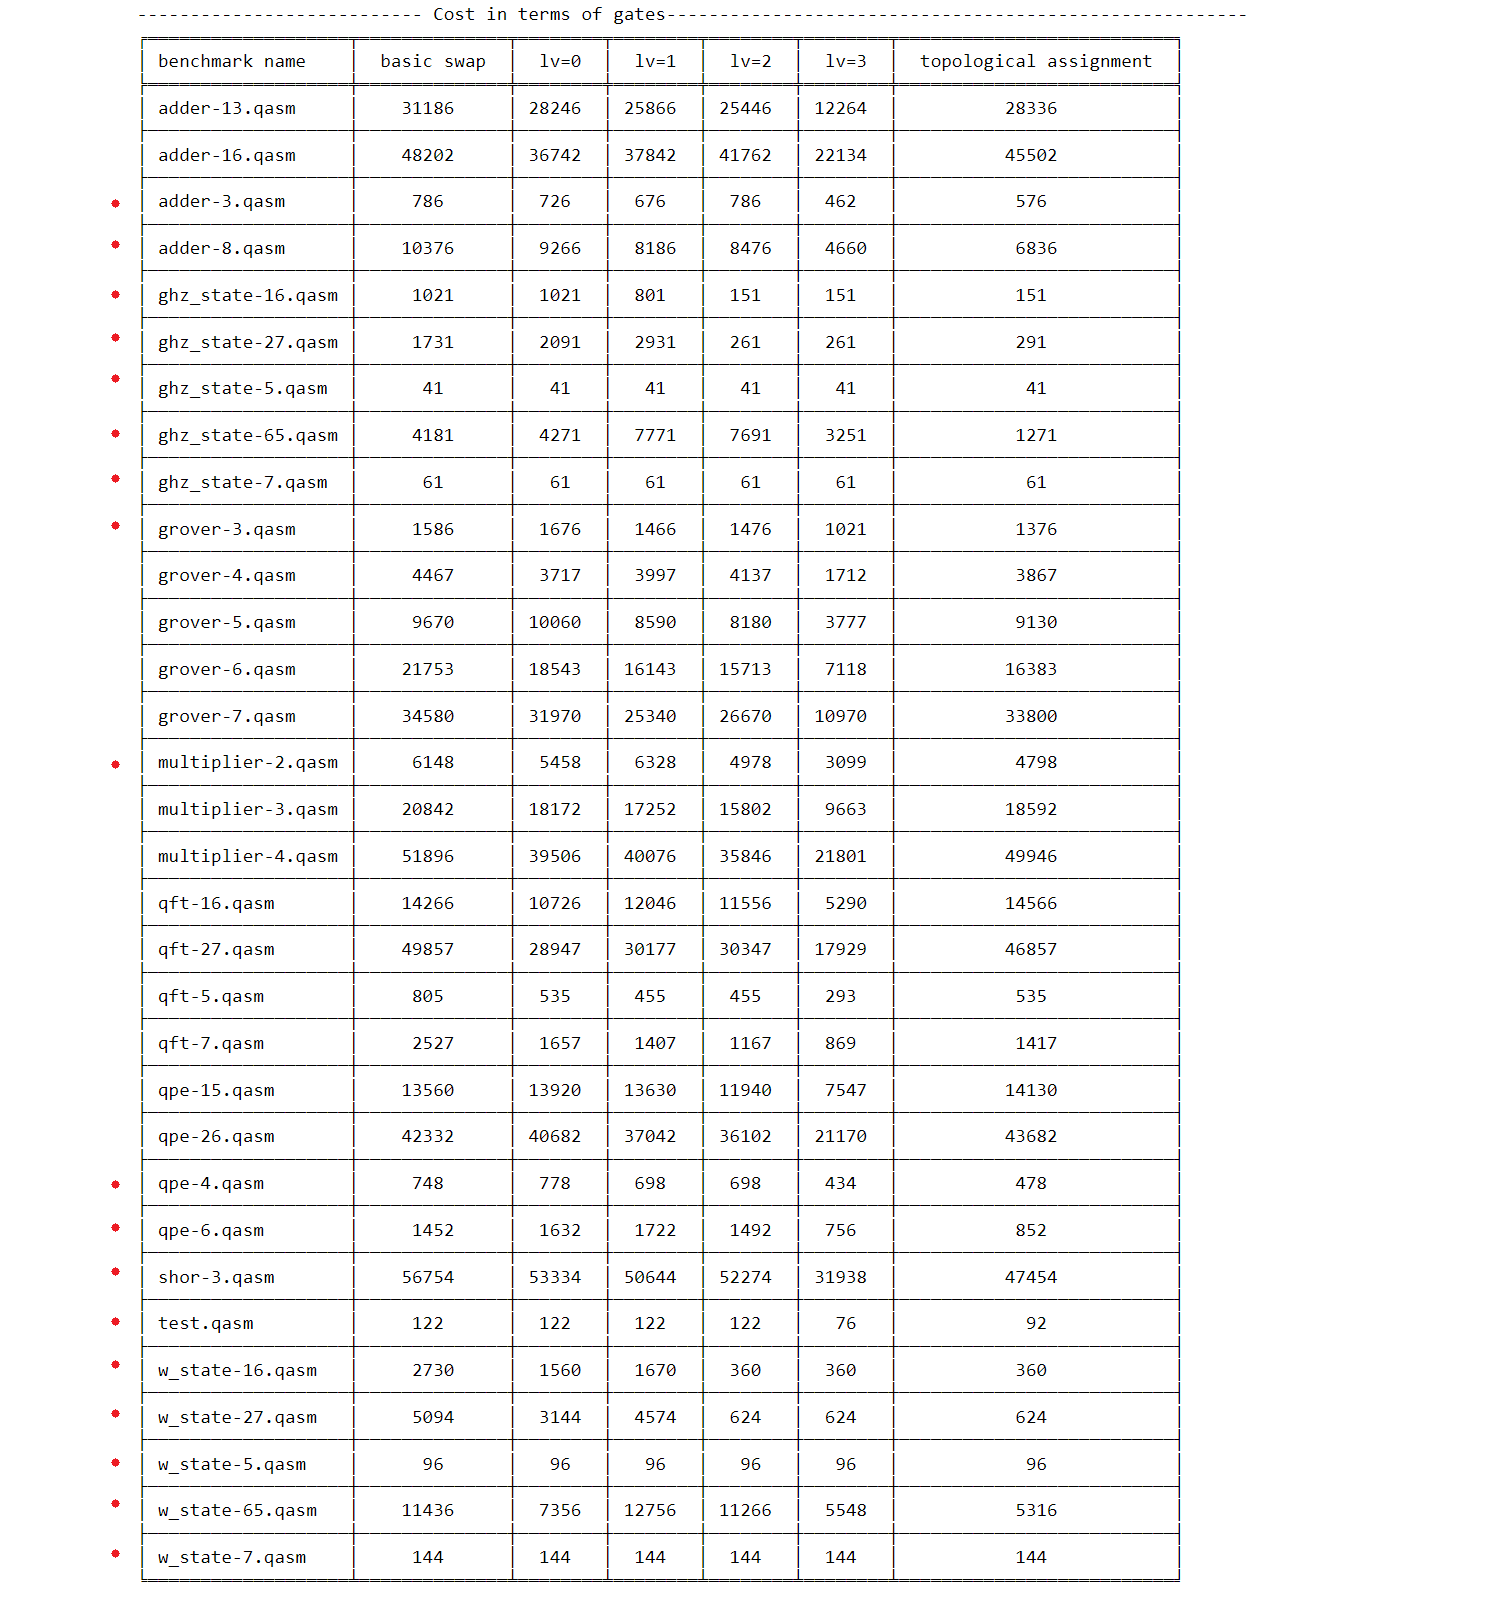

In [27]:
from IPython.display import Image
Image(filename='./output/comparison.png')

# What about time?
Even though is not required by the task, **I want to make a consideration about the timing**, which plays an important role as well (you can have the most efficient optimizer but if it takes 5 years per input it's quite useless...)

So, let's define a function that compute the execution time for multiple mappers and let's compare them

In [45]:
import time

In [49]:
# return a list of execution time with the following mappers: 
# basic_swap, lv0, lv1, lv2, lv3, topological_assignment
def compute_time(qc):
    
    # create a circuit the same size as the device, in terms of qubits and clbits
    new_qc = qc.copy()
    new_device_qc = QuantumCircuit(num_qubits, num_qubits)
    new_device_DAG = circuit_to_dag(new_device_qc) 
    new_initial_layout = Layout.generate_trivial_layout(*new_device_DAG.qregs.values())
    
    new_input_DAG = circuit_to_dag(new_qc) 
    
    # build the input_DAG on the device_DAG (65 qubits)
    new_device_DAG.compose(new_input_DAG)
    
    # for basic pass
    start = time.time()
    basic_pass = BasicSwap(coupling_map, new_initial_layout)
    new_dag_basic_pass = basic_pass.run(new_device_DAG)
    end = time.time()
    time_basic_pass = round(end - start, 3)
        
    # for traspiler lv0
    start = time.time()
    new_circ_lv0 = transpile(qc, backend=backend, optimization_level=0)
    new_dag_lv0 = circuit_to_dag(new_circ_lv0)
    end = time.time()
    time0 = round(end - start, 3)

    # for traspiler lv1
    start = time.time()
    new_circ_lv1 = transpile(qc, backend=backend, optimization_level=1)
    new_dag_lv1 = circuit_to_dag(new_circ_lv1)
    end = time.time()
    time1 = round(end - start, 3)

    # for traspiler lv2
    start = time.time()
    new_circ_lv2 = transpile(qc, backend=backend, optimization_level=2)
    new_dag_lv2 = circuit_to_dag(new_circ_lv2)
    end = time.time()
    time2 = round(end - start, 3)

    # for traspiler lv3
    start = time.time()
    new_circ_lv3 = transpile(qc, backend=backend, optimization_level=3)
    new_dag_lv3 = circuit_to_dag(new_circ_lv3)
    end = time.time()
    time3 = round(end - start, 3)
    
    # for topological assignment
    new_qc2 = qc.copy()
    new_input_DAG2 = circuit_to_dag(new_qc2) 
    
    # build the input_DAG on the device_DAG (65 qubits)
    new_device_qc2 = QuantumCircuit(num_qubits, num_qubits)
    new_device_DAG2 = circuit_to_dag(new_device_qc2) 
    new_device_DAG2.compose(new_input_DAG2)
    
    start = time.time()
    tp = topologicalAssignment(coupling_map)
    tp_layout = tp.run(new_device_DAG2)
    basic_pass_modified = BasicSwapModified(coupling_map, tp_layout)
    new_dag_tp_assignmnet = basic_pass_modified.run(new_device_DAG2)
    end = time.time()
    time_tp_assignment = round(end - start, 3)
    
    return [time_basic_pass, time0, time1, time2, time3, time_tp_assignment]

And now let's execute!

In [51]:
table_time_rows = []
for i in range(5):
#for i in range(len(filepaths)):
    print('------------iteration ', i, '-----------  file: ', filepaths[i], '----------')
    input_path4 = filepaths[i]
    qc4 = QuantumCircuit.from_qasm_file(path=input_path4)
    time_list = compute_time(qc4)
    
    row = [input_path4.rsplit('\\', 1)[1]]
    row.extend(time_list)
    table_time_rows.append(row) 
    
table_time = [['benchmark name', 'basic swap', 'lv=0', 'lv=1', 'lv=2', 'lv=3', 'topological assignment']]
table_time.extend(table_time_rows)

print('--------------------------- Execution time (in seconds) -------------------------------------------------------')
print(tabulate(table_time,headers='firstrow', tablefmt='fancy_grid', numalign='center'))

------------iteration  0 -----------  file:  .\original\adder-13.qasm ----------

-->This is how physical qubits have been assigned by the algorithm (in order):
 [31, 32, 30, 39, 45, 29, 33, 44, 46, 28, 25, 34, 24, 15, 35, 19, 27, 47, 43, 20, 14, 42, 48, 38, 18, 53]


Num of physical unique qubit assigned (without unused qubits): -- 26  out of  65

Num of physical unique qubit assigned (with used qubits): -- 65  out of  65
------------iteration  1 -----------  file:  .\original\adder-16.qasm ----------

-->This is how physical qubits have been assigned by the algorithm (in order):
 [31, 30, 32, 39, 45, 33, 29, 25, 34, 46, 44, 24, 28, 27, 35, 47, 48, 36, 38, 15, 14, 43, 53, 40, 19, 16, 20, 42, 52, 18, 41, 56]


Num of physical unique qubit assigned (without unused qubits): -- 32  out of  65

Num of physical unique qubit assigned (with used qubits): -- 65  out of  65
------------iteration  2 -----------  file:  .\original\adder-3.qasm ----------

-->This is how physical qubits have been 


-->This is how physical qubits have been assigned by the algorithm (in order):
 [31, 30, 32, 39, 33, 29, 45, 24, 34, 25, 44, 46, 28, 47, 35, 19]


Num of physical unique qubit assigned (without unused qubits): -- 16  out of  65

Num of physical unique qubit assigned (with used qubits): -- 65  out of  65
------------iteration  22 -----------  file:  .\original\qpe-26.qasm ----------

-->This is how physical qubits have been assigned by the algorithm (in order):
 [31, 39, 45, 30, 32, 29, 33, 25, 34, 46, 28, 24, 44, 15, 19, 43, 47, 35, 27, 42, 40, 16, 36, 53, 20, 18, 52]


Num of physical unique qubit assigned (without unused qubits): -- 27  out of  65

Num of physical unique qubit assigned (with used qubits): -- 65  out of  65
------------iteration  23 -----------  file:  .\original\qpe-4.qasm ----------

-->This is how physical qubits have been assigned by the algorithm (in order):
 [31, 30, 32, 39, 33]


Num of physical unique qubit assigned (without unused qubits): -- 5  out of  65





This is the **outcome**: we can see that where topological assignment performs quite good, it is also faster than a transpiler lv=3

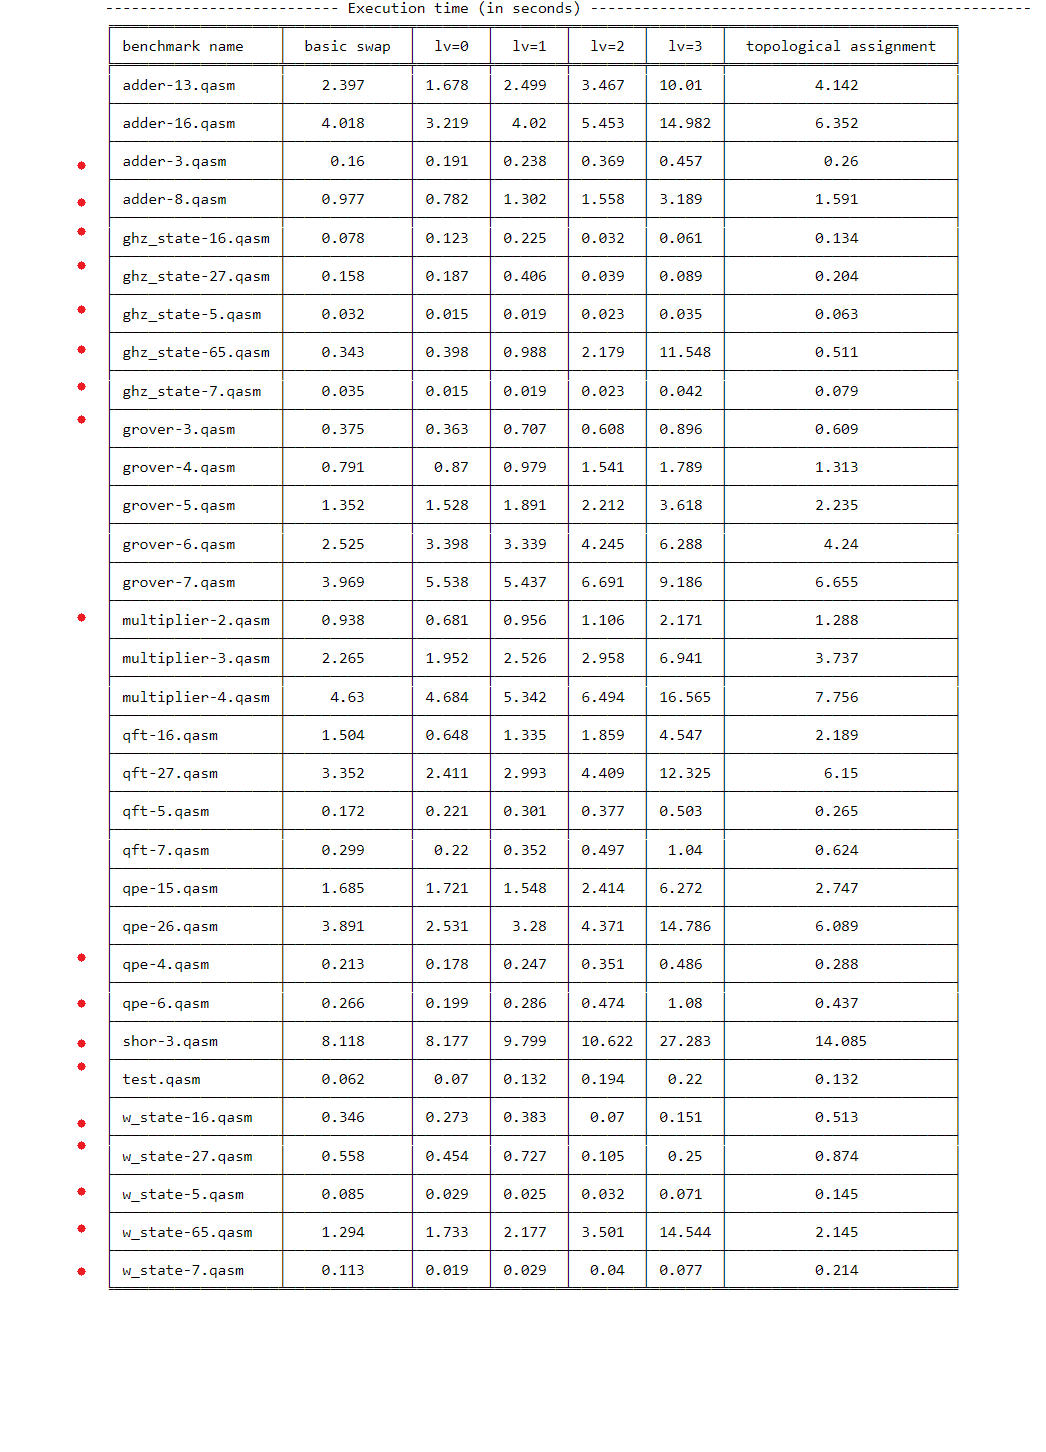

In [52]:
Image(filename='./output/comparison_time.png')